In [1]:
import simulate_data
import remove_data
import matrix_completion
import trunc_nnm
import errors

from sklearn.preprocessing import normalize
import numpy as np
import numpy.linalg as la
import pandas as pd

In [2]:
# simulate data
sim_df = simulate_data.sim_data(**simulate_data.sim_params)

# drop categorical feature for now
sim_df = sim_df.drop("Group", axis=1)

# Normalize data by feature (axis=0)
# norms we could use for re-scaling later
sim_norm, norms = normalize(sim_df, axis=0, return_norm=True)
pd.DataFrame(sim_norm).head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.160848,0.072637,0.076472,0.124035,0.000000,0.154303,0.104828,-0.0,0.011904,0.161364,0.075564
1,0.155974,0.105401,0.000000,0.000000,0.000000,0.000000,0.104828,0.0,0.000000,0.024425,0.100898
2,0.136477,0.067953,0.000000,0.124035,0.000000,0.154303,0.104828,0.0,0.000000,0.100390,0.068334
3,0.126729,0.077813,0.076472,0.124035,0.447214,0.000000,0.104828,0.0,0.000000,0.138487,0.079118
4,0.116980,0.071644,0.000000,0.124035,0.000000,0.000000,0.000000,0.0,0.000000,0.185866,0.075076


In [3]:
# NNM parameters
parameters = {"eps_outer": 1e-6,
              "eps_inner": 1e-6,
              "beta": 1,
              "max_iter_outer": 100,
              "max_iter_inner": 100}

# Missing at Random

### How do error rates vary by rate of missingness?

In [37]:
results_lst = []

for missingness_pct in np.arange(0, 100, 5):
    sim_obs = remove_data.missing_at_random(sim_norm, perc_remove=missingness_pct, rand_seed=23)
    
    rank = la.matrix_rank(sim_norm)
    sim_recovered_nnm = trunc_nnm.truncated_NNM(rank, parameters, sim_obs)
    nnm_error = la.norm(sim_norm - sim_recovered_nnm, ord='fro')

    sim_obs = remove_data.missing_at_random(sim_norm, perc_remove=missingness_pct, rand_seed=23)

    sim_recovered_svt = matrix_completion.svt(sim_obs, tau=0.5, stop_threshold=1e-3, max_iter=2000)
    svt_error = la.norm(sim_norm - sim_recovered_svt, ord='fro')
    
    results_lst.append([missingness_pct, svt_error, nnm_error])

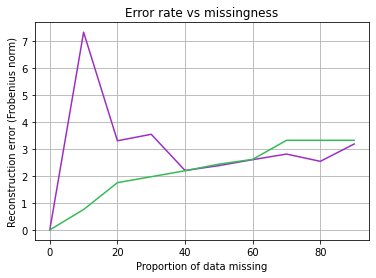

In [36]:
results_df = pd.DataFrame(results_lst, columns=["missingness", "SVT", "NNM"]).set_index("missingness")
# TODO: Add legend
errors.line_plot(results_df.index, results_df.SVT, results_df.NNM)

NNM seems to be pretty stable across parameters, but SVT results can change depending on $\tau$. SVT seems to converve with NNM results quite exactly when $\tau$ is really small or really large.

##### Here we hold the error rate at 40% and change $\tau$ for SVT

In [ ]:
tau_lst = []

for tau in np.arange(0, 10, 1):
    sim_obs = remove_data.missing_at_random(sim_norm, perc_remove=40, rand_seed=23)
    
    sim_recovered_svt = matrix_completion.svt(sim_obs, tau=tau)
    svt_error = la.norm(np.round(sim_norm, 4) - np.round(sim_recovered_svt, 4), ord='fro')
    
    tau_lst.append([tau, svt_error])

In [ ]:
tau_df = pd.DataFrame(tau_lst, columns=["tau", "error"]).set_index("tau")
tau_df.plot(title="Error rate depending on tau")

SVT seems to want $\tau$ to be somewhere midway between 0 and the rank of the original matrix. Should test on other data.

### How do error rates vary by rank of the matrix?

In [ ]:
# NNM parameters
parameters = {"eps_outer": 1e-6,
              "eps_inner": 1e-6,
              "beta": 1,
              "max_iter_outer": 1000,
              "max_iter_inner": 1000}


Here we vary rank for a synthetic dataset with 10% missing values

In [48]:
results_lst = []
n = 20
p = 10
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

for rank in range(1,p):

    # Produce r-rank data
    data = simulate_data.create_rank_r_matrix(rank, n, p)

    # Set to only 10% missing
    sim_obs = remove_data.missing_at_random(data, perc_remove=10, rand_seed=23)

    sim_recovered_svt = matrix_completion.svt(sim_obs, tau=10, stop_threshold=.0001)
    svt_error = la.norm(data - sim_recovered_svt, ord='fro')

    # reproduce same matrix
    sim_obs = remove_data.missing_at_random(data, perc_remove=10, rand_seed=23)
    sim_recovered_nnm = trunc_nnm.truncated_NNM(rank, parameters, sim_obs)
    nnm_error = la.norm(data - sim_recovered_nnm, ord='fro')

    results_lst.append([rank, svt_error, nnm_error])

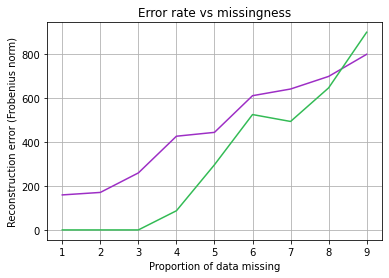

In [49]:
results_df = pd.DataFrame(results_lst, columns=["rank", "SVT", "NNM"]).set_index("rank")
# TODO: Add legend and update axes
errors.line_plot(results_df.index, results_df.SVT, results_df.NNM)

The reconstruction error increases fairly linearly with rank.

### How do error rates vary by the type of missingness?

In [52]:
# remove the last column
original_normalized_arr = sim_norm[:,:10]

In [53]:
def conditionally_remove_data(df, perc_missing):

    # make Income missing conditional on age
    sim_df = remove_data.missing_conditional_continuous(df, 
                                                     "Income", 
                                                     "Income", 
                                                     percent_missing=perc_missing)

    # make Age missing conditional on itself
    sim_df = remove_data.missing_conditional_continuous(sim_df, 
                                                     "Age", 
                                                     "Age", 
                                                     percent_missing=perc_missing)

    # make NChild missing conditional on Continuous_EvenLikelihood_0
    sim_df = remove_data.missing_conditional_continuous(sim_df, 
                                                     "NChild", 
                                                     "Continuous_EvenLikelihood_0", 
                                                     percent_missing=perc_missing)


    # # make Continuous_LowLikelihood_0 missing conditional on Continuous_HighLikelihood_0
    sim_df = remove_data.missing_conditional_continuous(sim_df, 
                                                     "Continuous_LowLikelihood_0", 
                                                     "Continuous_HighLikelihood_0", 
                                                     percent_missing=perc_missing)

    # # make Continuous_EvenLikelihood_0 missing conditional on itself
    sim_df = remove_data.missing_conditional_continuous(sim_df, 
                                                     "Continuous_EvenLikelihood_0", 
                                                     "Continuous_EvenLikelihood_0", 
                                                     percent_missing=perc_missing)

    # # make Continuous_HighLikelihood_0 missing conditional on itself
    sim_df = remove_data.missing_conditional_continuous(sim_df, 
                                                     "Continuous_HighLikelihood_0", 
                                                     "Continuous_HighLikelihood_0", 
                                                     percent_missing=perc_missing)

    # conditionally remove entries from each discrete variable
    sim_df = remove_data.missing_conditional_discrete(sim_df, 
                                                    'InCensus', perc_missing)
    sim_df = remove_data.missing_conditional_discrete(sim_df, 
                                                    'Discrete_LowLikelihood_0', perc_missing)
    sim_df = remove_data.missing_conditional_discrete(sim_df, 
                                                    'Discrete_EvenLikelihood_0', perc_missing)
    sim_df = remove_data.missing_conditional_discrete(sim_df, 
                                                    'Discrete_HighLikelihood_0', perc_missing)
    sim_df = remove_data.missing_conditional_discrete(sim_df, 
                                                    'Discrete_LowLikelihood_0', perc_missing)
    
    return sim_df

In [54]:
# test the conditionally_remove_data function
original_normalized_df = pd.DataFrame(original_normalized_arr, columns=sim_df.columns[:10])
sim_conditional_missing = conditionally_remove_data(original_normalized_df, perc_missing=30)

In [55]:
# confirm that Continuous_LowLikelihood_0 is missing for those with low values of Continuous_HighLikelihood_0
sim_conditional_missing[['Continuous_HighLikelihood_0', 'Continuous_LowLikelihood_0']].sort_values("Continuous_HighLikelihood_0")[:10]

,Continuous_HighLikelihood_0,Continuous_LowLikelihood_0
11,0.028401,NaN
60,0.039314,NaN
82,0.044695,NaN
74,0.046560,0.0
64,0.047800,NaN
41,0.049527,-0.0
10,0.049712,NaN
9,0.053248,0.0
25,0.055209,0.0
78,0.060993,0.0


In [56]:
# check total missingness in conditional missing
conditional_total_missingness = pd.DataFrame(sim_conditional_missing).isnull().sum().sum() / pd.DataFrame(sim_conditional_missing).size
print(conditional_total_missingness)

# view missingness for features in conditional missing
sim_conditional_missing.isnull().mean()

0.3


Age                            0.29
Income                         0.29
NChild                         0.30
InCensus                       0.27
Discrete_LowLikelihood_0       0.44
Discrete_EvenLikelihood_0      0.27
Discrete_HighLikelihood_0      0.23
Continuous_LowLikelihood_0     0.32
Continuous_EvenLikelihood_0    0.31
Continuous_HighLikelihood_0    0.28
dtype: float64

In [57]:
# create randomly missing data matching the missingness of the conditional data
sim_random_missing = remove_data.missing_at_random(original_normalized_arr, perc_remove=conditional_total_missingness*100, rand_seed=23)

In [58]:
# check total missingness in random missing
print(pd.DataFrame(sim_random_missing).isnull().sum().sum() / pd.DataFrame(sim_random_missing).size)

# view missingness for features in random missing
pd.DataFrame(sim_random_missing, columns=original_normalized_df.columns).isnull().mean()

0.3


Age                            0.28
Income                         0.23
NChild                         0.32
InCensus                       0.35
Discrete_LowLikelihood_0       0.34
Discrete_EvenLikelihood_0      0.20
Discrete_HighLikelihood_0      0.30
Continuous_LowLikelihood_0     0.34
Continuous_EvenLikelihood_0    0.34
Continuous_HighLikelihood_0    0.30
dtype: float64

In [62]:
results_lst = []

for missingness_pct in range(0, 100, 10):
    sim_conditional_missing = conditionally_remove_data(original_normalized_df, perc_missing=missingness_pct)
    
    # check total missingness in conditional missing
    conditional_total_missingness = pd.DataFrame(sim_conditional_missing).isnull().sum().sum() / pd.DataFrame(sim_conditional_missing).size
    
    # create randomly missing data matching the missingness of the conditional data
    sim_random_missing = remove_data.missing_at_random(original_normalized_arr, perc_remove=conditional_total_missingness*100, rand_seed=23)

    # random missing
    sim_recovered_random_svt = matrix_completion.svt(sim_random_missing, 
                                                     tau=.3, 
                                                     verbose=True, 
                                                     stop_threshold=0.01)
    random_svt_error = la.norm(original_normalized_arr - sim_recovered_random_svt, ord='fro')

#     sim_recovered_random_nnm = trunc_nnm.truncated_NNM(10, parameters, sim_random_missing)
#     random_nnm_error = la.norm(np.round(original_normalized_data, 4) - np.round(sim_recovered_random_nnm, 4), ord='fro')

    # conditional missing
    #sim_recovered_conditional_svt = matrix_completion.svt(sim_conditional_missing, tau=5)
    #conditional_svt_error = la.norm(original_normalized_arr -sim_recovered_conditional_svt, ord='fro')

#     sim_recovered_conditional_nnm = trunc_nnm.truncated_NNM(10, parameters, sim_conditional_missing)
#     conditional_nnm_error = la.norm(np.round(original_normalized_data, 4) - np.round(sim_recovered_conditional_nnm, 4), ord='fro')

    #results_lst.append([conditional_total_missingness, random_svt_error, conditional_svt_error])

s in first iter [2.381 1.03  0.997 0.747 0.734 0.663 0.516 0.472 0.388 0.271]
total iter: 1


KeyboardInterrupt: 

In [ ]:
svt_errors = pd.DataFrame(results_lst, columns=['missingness','random','conditional']).set_index('missingness')

In [ ]:
svt_errors

In [ ]:
errors.line_plot(svt_errors.index, svt_errors.random, svt_errors.conditional)
# TODO: change axes labels
# TODO: add legend